In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight,shuffle
from imgaug import augmenters as iaa
import skimage.io
import imgaug as ia
from keras.utils import Sequence
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate)
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.optimizers import Adam 
import numpy as np
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from tqdm import tqdm
from keras.callbacks import Callback
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
import tensorflow as tf
from keras.losses import binary_crossentropy, categorical_crossentropy

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
os.listdir("../input")

['kappa-09192-train',
 'aptos2019-blindness-detection',
 'pretrained-net',
 'dense-net']

In [3]:
ls ../input/kappa-09192-train/densenet_bestqwk.h5

../input/kappa-09192-train/densenet_bestqwk.h5


In [4]:
NUM_CLASSES = 5
SIZE = 300

In [5]:
ls

__notebook_source__.ipynb  training_log.csv


In [6]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [7]:
df_train.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

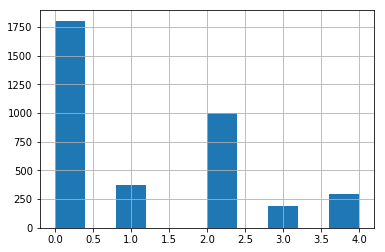

In [8]:
x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=8)
y.hist()

In [9]:
print(x.shape)
print(y.shape)

(3662,)
(3662,)


In [10]:
import collections
collections.Counter(df_train['diagnosis'])

Counter({2: 999, 4: 295, 1: 370, 0: 1805, 3: 193})

In [11]:
y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x,train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(3112,)
(3112, 5)
(550,)
(550, 5)


In [12]:
type(train_x)

pandas.core.series.Series

In [13]:
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=0)
#train_x,train_y = ros.fit_resample(b_train_x.values.reshape(-1,1),b_train_y)

In [14]:
print(train_x.shape, train_y.shape)

(3112,) (3112, 5)


In [15]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

In [16]:
seq = iaa.Sequential(
        [
           
            iaa.Fliplr(0.5),
            iaa.Flipud(0.2), 
            sometimes(iaa.Affine(
                scale={"x": (1.1, 1.5), "y": (1.1, 1.5)},
                translate_percent={"x": (-0.1, 0.2), "y": (-0.1, 0.1)},
                rotate=(-10, 10), 
                shear=(-5, 5), 
                order=[0, 1],
                cval=(0, 255),
                mode=ia.ALL
            )),
            iaa.SomeOf((0, 4),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))),
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)),
                        iaa.AverageBlur(k=(3, 5)),
                        iaa.MedianBlur(k=(3, 5)),
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)),
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
                   
                    #iaa.SimplexNoiseAlpha(iaa.OneOf([
                     #   iaa.EdgeDetect(alpha=(0.5, 1.0)),
                     #   iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    #])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5),
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5),
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True),
                    iaa.Add((-2, 2), per_channel=0.5),
                    iaa.AddToHueAndSaturation((-1, 1)),
                    
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        #iaa.FrequencyNoiseAlpha(
                        #    exponent=(-1, 0),
                        #    first=iaa.Multiply((0.9, 1.1), per_channel=True),
                        #    second=iaa.ContrastNormalization((0.9, 1.1))
                        #)
                    ])#,
                    #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
                    #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                    #sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True)

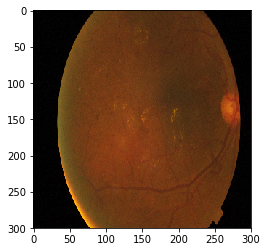

In [17]:
img = cv2.imread('../input/aptos2019-blindness-detection/train_images/000c1434d8d7.png')
img = cv2.resize(img, (SIZE, SIZE))
img = seq.augment_image(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [18]:
class Custom_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

In [19]:
# this code reference from : https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow
def kappa_loss(y_true, y_pred, y_pow=2, eps=1e-12, N=5, bsize=32, name='kappa'):
    """A continuous differentiable approximation of discrete kappa loss.
        Args:
            y_pred: 2D tensor or array, [batch_size, num_classes]
            y_true: 2D tensor or array,[batch_size, num_classes]
            y_pow: int,  e.g. y_pow=2
            N: typically num_classes of the model
            bsize: batch_size of the training or validation ops
            eps: a float, prevents divide by zero
            name: Optional scope/name for op_scope.
        Returns:
            A tensor with the kappa loss."""

    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom*0.5 / (denom + eps) + categorical_crossentropy(y_true, y_pred)*0.5

In [21]:
from keras.models import load_model
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = DenseNet121(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights("../input/dense-net/DenseNet-BC-121-32-no-top.h5")
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output) 
    #model = load_model('../input/pretrained-net/densenet_bestqwk.h5', custom_objects={'kappa_loss': kappa_loss})
    model.load_weights('../input/pretrained-net/densenet_bestqwk.h5')
    set_trainable = False
    for layer in model.layers:
        if layer.name.find("conv5") != -1:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return model

In [22]:
ls ../input/dense-net

DenseNet-BC-121-32-no-top.h5


In [23]:
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES)

In [24]:
# print(model.summary())

In [25]:
# for lay in model.layers:
#     print(lay.name, lay.trainable)

In [26]:
epochs = 10; batch_size = 5
checkpoint = ModelCheckpoint('../working/densenet_{epoch}_.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)
train_mixup = Custom_Generator(train_x, train_y, batch_size, is_train=True, mix=False, augment=True)
valid_generator = Custom_Generator(valid_x, valid_y, batch_size, is_train=False)

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [27]:

class Quad_Weighted_Kappa(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - Quad_Wtd_Kappa_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('../working/densenet_bestqwk_v1.h5')

quad_w_kappa = Quad_Weighted_Kappa(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [28]:
#model = create_model(
#    input_shape=(SIZE,SIZE,3), 
#    n_out=NUM_CLASSES)
#categorical_crossentropy
def run_model():
    for layer in model.layers:
        layer.trainable = True
    callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, quad_w_kappa]
    model.compile(loss=kappa_loss
                  ,optimizer=Adam(lr=1e-4))
    model.fit_generator(
        train_mixup,
        steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
        validation_data=valid_generator,
        validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
        epochs=epochs,
        verbose=1,
        workers=2, use_multiprocessing=True,
        callbacks=callbacks_list)
run_model()

Epoch 1/10
623/623 [==============================] - 349s 560ms/step - loss: 1.8522 - val_loss: 1.1281
Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.12808, saving model to ../working/densenet_1_.h5
110/110 [==============================] - 43s 391ms/step

 epoch: 1 - Quad_Wtd_Kappa_score: 0.851015 

saving checkpoint:  0.8510152300190976
Epoch 2/10
623/623 [==============================] - 317s 509ms/step - loss: 1.6468 - val_loss: 1.1270

Epoch 00002: val_loss improved from 1.12808 to 1.12697, saving model to ../working/densenet_2_.h5

Epoch 00001: val_loss improved from inf to 1.12808, saving model to ../working/densenet_1_.h5
110/110 [==============================] - 43s 394ms/step

 epoch: 2 - Quad_Wtd_Kappa_score: 0.839873 

Epoch 3/10
623/623 [==============================] - 297s 477ms/step - loss: 1.5574 - val_loss: 1.0144

Epoch 00003: val_loss improved from 1.12697 to 1.01441, saving model to ../working/densenet_3_.h5
110/110 [==============================] -

In [30]:
predicted = []
submit = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
def predict(base_path):
    model.load_weights('../working/densenet_bestqwk_v1.h5')
    for i, name in tqdm(enumerate(submit['id_code'])):
        path = os.path.join(base_path+'test_images/', name+'.png')
        #print(path)
        image = cv2.imread(path)
        image = cv2.resize(image, (SIZE, SIZE))
        X = np.array((image[np.newaxis])/255)
        score_predict=((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
        label_predict = np.argmax(score_predict)
        predicted.append(str(label_predict))
        #break

predict('../input/aptos2019-blindness-detection/')

1928it [03:33,  9.02it/s]


In [ ]:
# ../input/aptos2019-blindness-detection/test_images/0005cfc8afb6.png


In [ ]:
# submit['diagnosis'] = predicted
# submit.to_csv('submission.csv', index=False)
# submit.head()

In [31]:
traing_log = pd.read_csv("../working/training_log.csv")

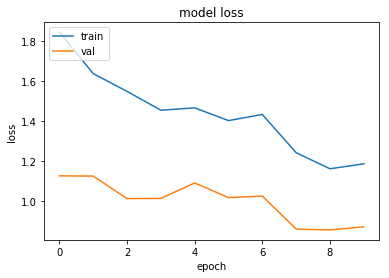

In [32]:
import keras
from matplotlib import pyplot as plt
#history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(traing_log['loss'])
plt.plot(traing_log['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()